Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Number of metagenomes = 6
Total counts for each metagenone:  [38228, 18354, 21353, 11919, 18447, 17611]



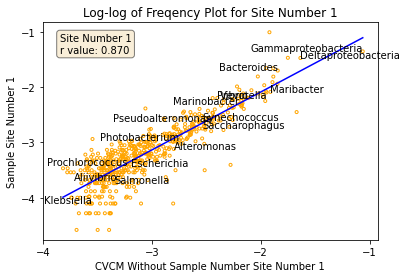

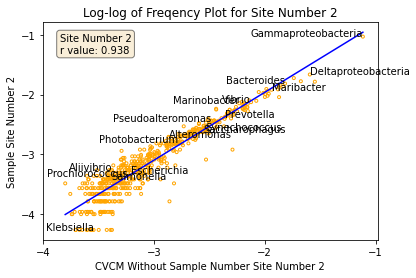

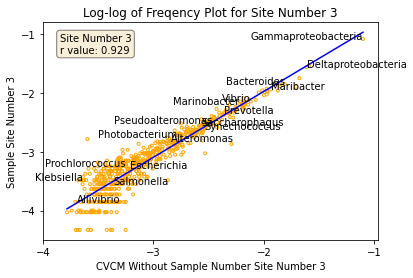

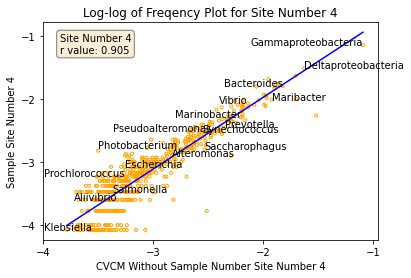

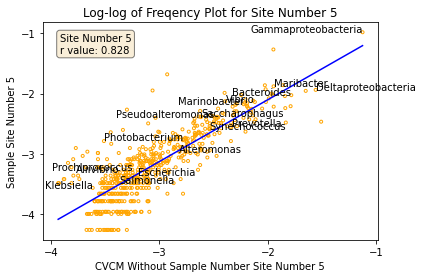

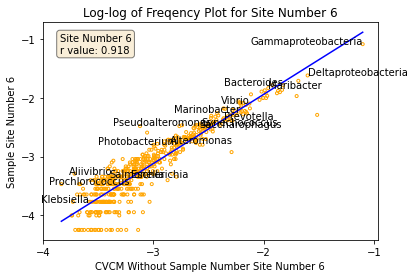

Done!


In [34]:
"""PROGRAM TO COMBINE METAGENOMES INTO A SINGLE DATASET WITH GENERA, AVERAGED 
GENUS FREQUENCIES, STD ERRORS NORMALIZED BY FREQUENCY, AND LOG10 OF FREQUENCIES.
FREQUENCY AND NORMALIZED STD ERORS ARE MULTIPLIED BY 1000 TO AVOID EXCEL'S 
LOW-NUMBER PROBLEM.  SO, THOSE VALUES HAVE TO BE DIVIED BY 1000 WHEN USED BY
OTHER PROGRAMS. 
"""
seektaxa = ['Alteromonas', 'Saccharophagus', 'Pseudoalteromonas' , 'Photobacterium', 'Marinobacter', 'Aliivibrio' , 'Prochlorococcus', 
            'Synechococcus','Gammaproteobacteria', 'Deltaproteobacteria', 'Escherichia', 'Salmonella', 'Proteus', 'Klebsiella', 
            'Bacteroides', 'Prevotella', 'Shigella', 'Vibrio', 'Maribacter' ]
FINDtaxalabels = True 
Wilcoxonlabels = False
numprocess = 410
import math
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

#1. THE OUTFILE NAME. IF A MG IS TO LEFT LEFT OUT,INSERT IT IN PLACE OF THE "0":
outname = '/content/gdrive/Shared drives/4.Venetian Canals/Output Files/dummy_name'

# s1l1, s2l3, s3l2, s4l1, s5l3, s6l2
#2. PASTE IN THE NAMES OF ALL THE INPUT METAGENOME FILES: 
files = ['/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site1.Loop1.TRANSPOSED.csv',
         '/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site2.Loop3.TRANSPOSED.csv',
         '/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site3.Loop2.TRANSPOSED.csv',
         '/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site4.Loop1.TRANSPOSED.csv',
         '/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site5.Loop3.TRANSPOSED.csv',
         '/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site6.Loop2.TRANSPOSED.csv']
outfiles = ['/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site1.Loop1.Deviants.csv',
            '/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site2.Loop3.Deviants.csv',
            '/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site3.Loop2.Deviants.csv',
            '/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site4.Loop1.Deviants.csv',
            '/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site5.Loop3.Deviants.csv',
            '/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Site6.Loop2.Deviants.csv']         
nummetas =  len(files)
mglabel =[]
for x in range(nummetas):
  mglabel.append('Site Number ' + str(files[x][74:75]))

stringmetas =[]
for x in range(nummetas):   # for reading files and converting each taxon to a list of [taxon, number]
  with open(files[x], 'r') as f:
    data = f.read()
    #print(repr(data)[:100])    
    #print(repr(data)[-100:])
    stringmetas.append(str(data))
  f.close()
print('Number of metagenomes =', len(stringmetas))

cleanmetas =[]            # gets rid of unwanted test, converts number from string to integer
for x in range(nummetas):
  datastring = stringmetas[x].replace('unclassified (derived from ', '').replace(')', '').replace('Candidatus ', '')
  metalines = datastring.split('\n')
  #print(metalines)
  metalines.pop()
  integermeta =[]
  for y in range(len(metalines)):
    row = metalines[y].split(',')
    integermeta.append([row[0], int(row[1])])
  cleanmetas.append(integermeta)

for a in range(nummetas):
  cleanmetas[a].sort(key = lambda x: x[1])
  cleanmetas[a].reverse()

totalslist =[]             # counts the total number of taxa in each metagenome
for x in range(nummetas):
  count =0
  for y in range(len(cleanmetas[x])):
    count += cleanmetas[x][y][1]
  totalslist.append(count)
print('Total counts for each metagenone: ', totalslist)

for x in range(nummetas):
  for y in range(len(cleanmetas[x])):
    cleanmetas[x][y].append(cleanmetas[x][y][1] / totalslist[x])

### Above: cleanmetas is a list of all mgs with their taxa, numbers, and frqs.  mgs are not trimmed to numprocess
### Below: make taxonset and taxonlist that are the union of the 'numprocess' genera

def reset(lst):
  taxonset = set()
  taxonlist =[]
  for x in range(nummetas):
    for y in range(numprocess):
      if cleanmetas[x][y][0] not in taxonset:
        taxonset.add(cleanmetas[x][y][0])
        taxonlist.append([cleanmetas[x][y][0], 0.0001, 0.0001])
  return(taxonlist)

### routine for plotting each mg against a cvcm made using all other mgs.
deviantslist =[]
for w in range(nummetas):  
  print()
  x1, y1, x5, y5, plttaxa = [], [], [], [], []
  looplist = reset(cleanmetas)
  for a in range(nummetas):
    if a == w:
      for b in range(len(cleanmetas[a])):
        for c in range(len(looplist)):
          if cleanmetas[a][b][0] == looplist[c][0]:
            looplist[c][1] = cleanmetas[a][b][2]
    elif a != w:
      for b in range(len(cleanmetas[a])):
        for c in range(len(looplist)):
          if cleanmetas[a][b][0] == looplist[c][0]:
            looplist[c][2] +=  cleanmetas[a][b][2]  / (nummetas -1)  
  for d in range(len(looplist)):
    x1.append(math.log(looplist[d][2], 10))
    y1.append(math.log(looplist[d][1], 10))
    for e in range(len(seektaxa)):
      if seektaxa[e].lower() == looplist[d][0].lower():
        x5.append(math.log(looplist[d][2], 10))
        y5.append(math.log(looplist[d][1], 10))
        plttaxa.append(seektaxa[e])    
  slope, intercept, r_value, p_value, std_err = stats.linregress(x1,y1)
  for m in range(len(looplist)):
    looplist[m].append(abs(looplist[m][1] - looplist[m][2]))
  looplist.sort(key = lambda x: x[3])
  looplist.reverse()
  x2, y2, deviants, tags = [], [], [], []
  for m in range(round(len(looplist) / 10)):
    x2.append(math.log(looplist[m][2], 10))
    y2.append(math.log(looplist[m][1], 10))  
    tags.append(looplist[m][0][:])                        
    deviants.append(looplist[m])
  x4 = [min(x1), max(x1)]
  y4 = [min(x1) * slope + intercept, max(x1) * slope + intercept]
  fig, ax = plt.subplots()
  textstr = mglabel[w] +'\n' + 'r value: ' + str(r_value)[:5] 
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  # place a text box in upper left in axes coords
  ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
  plt.scatter(x1, y1, marker = '.', facecolors= 'none', edgecolors = 'orange')       # scatter allows plotting with open circles
  #plt.scatter(x2, y2, marker = '+', color = 'b')       # scatter allows plotting with open circles
  if Wilcoxonlabels == True: 
    for p in range(len(tags)):
      if q % 2 == 0: ha = 'right'
      else: ha = 'left'
      plt.text(x2[p], y2[p], tags[p], color='r', horizontalalignment='right')
  if FINDtaxalabels == True:
    for q in range(len(x5)):
      if q % 2 == 0: ha = 'right'
      else: ha = 'left'
      plt.text(x5[q], y5[q], plttaxa[q], horizontalalignment=ha)
  plt.plot(x4,y4, marker = '', color = 'b')                                    # plot allows plotting with connected lines
  plt.title('Log-log of Freqency Plot for ' + mglabel[w])
  plt.xlabel('CVCM Without Sample Number ' + mglabel[w])
  plt.ylabel('Sample ' + mglabel[w])
  plt.xticks(np.arange(-4, 0, step=1))
  plt.yticks(np.arange(-4, 0, step=1))

  plt.show()
  deviantslist.append(deviants)

for w in range(len(outfiles)):
  with open(outfiles[w], 'w') as g:
    for x in range(len(deviantslist[w])):
      outline = deviantslist[w][x][0] + ',' + str(deviantslist[w][x][1]) + ','\
        + str(deviantslist[w][x][2]) + ',' +  str(deviantslist[w][x][3]) +'\n'
      g.write(outline)
  g.close()

print('Done!')
